In [1]:
import struct
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# create dictionaries to store the data
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

In [2]:
train = dict()
test = dict()

In [3]:
def get_images(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        print(magic, size, rows, cols)
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape (size, rows, cols)

In [4]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

2051 60000 28 28
2051 10000 28 28
(60000, 28, 28) (10000, 28, 28)


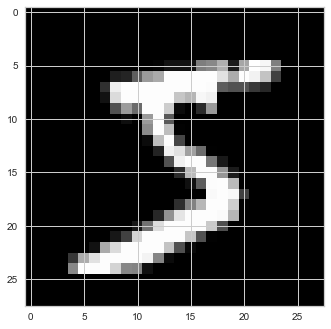

In [5]:
fig , ax = plt.subplots()
ax.imshow(train['image'][0], cmap = 'gray')

In [6]:
def get_labels(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read( 8 ))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [7]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


In [8]:
#check that labels are between expected values
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
print(train['image'][0].shape)

(28, 28)


**"Without any assumptions on the noise, the linear least squares solution for any i.i.d. sample will typically be biased w.r.t. the least squares optimum over the entire distribution. However, we show that if an i.i.d. sample of any size k is augmented by a certain small additional sample, then the solution of the combined sample becomes unbiased."** In this case I called that vector $\beta_0 $ so that:
\Y(X) =
  \begin{cases}
    1       & \quad\ X^{T}\beta + \beta_0 = k\\
    -1  & \quad\ X^{T}\beta + \beta_0 \neq k
  \end{cases}
\


$k \in [0,1, 2, ..., 9]$

but if we incorporate a zeroth column of 1's into  X we can likewise include $\beta_0$ in the complete coefficient vector $\beta$ and write our model in the more compact form:

$
Y(X) = X^T \beta
$

In this case $\beta$ will determine the equation of the line given by Y so

$
\beta = (X^T X)^{-1}X^TY 
$

 


Now that we have $\beta$ we can calculate the residual sum of squares and then calculate the residual standard error to plot:

$RSS(\beta)$ =  $\sum_{i=1}^N (y_i−x^{T_i}\beta)^2 $

$RSE = [RSS(\beta)/(n-2)]^{1/2}$

In [10]:
def oneD_bias_img(image):
    #create a zero array and makes images 1D
    flat = np.zeros((image.shape[0], np.product(image.shape[1:])))
    for i in range(flat.shape[0]):
        flat[i] = image[i].flatten()
    #adds a column of 1's to prevent bias for i.i.d r.v.
    unbias_array = np.concatenate([flat, np.ones((flat.shape[0], 1))], axis=1)
    return unbias_array
    
def binary_response(labels, number):
    """takes the labels array and a number you would like the model to recognize
    it returns an array of 1 and -1 depending if the target value was found"""
    binary_col = np.zeros((labels.shape[0], 1))   
    for i in range(binary_col.shape[0]):
        
        if labels[i] == number:
            binary_col[i] = 1
        else:
            binary_col[i] = -1
    return binary_col

def beta(x, y):
    b = np.matmul(np.linalg.pinv(np.matmul(x.transpose(), x)), np.matmul(x.transpose(), y))
    return b
def sigmoid(x, beta):
    return 1/(1+ np.exp(x@betaa))

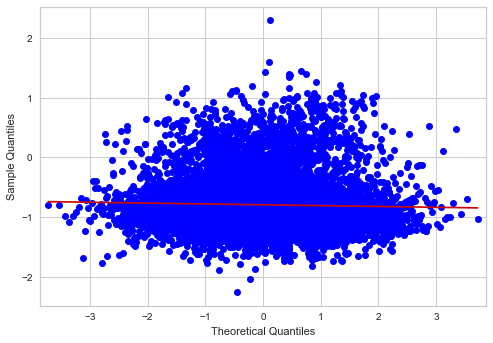

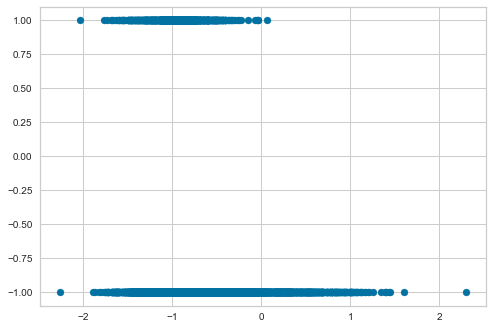

In [21]:
for t in range(0,10):
    #prepares data to be process and computes Beta
    x = oneD_bias_img(train['image'])
    y_train = binary_response(train['label'], t)
    betaa  = beta(x,y)
    
    # prepares the images to test our model
    x_test = oneD_bias_img(test['image'])
    y_pred = x_test@betaa
    y_test = binary_response(test['label'], t)
    
    sm.qqplot(y_pred, line ='r')
    plt.show()
    #plots tan h line with bounds from -1, 1
    #tanh = np.tanh(np.arange(len(y_pred)))
    #prints 
    plt.scatter((y_pred), (y_test))
    #plt.plot(tanh)
    plt.show()
    break

## 2 using logistic Regression:

In [56]:
def confusing_plot(con_matrix, name = None):
    class_names=[-1,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.array([-1,1])
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap fmt='g'
    sns.heatmap(confusion_matrixx, annot=True, cmap="YlGnBu",fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if name != None:
        plt.savefig(name)
    plt.show()

In [25]:
from __future__ import division
from scipy.stats.contingency import margins

def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

def stdres(observed, expected):
    n = observed.sum()
    rsum, csum = margins(observed)
    # With integers, the calculation
    #     csum * rsum * (n - rsum) * (n - csum)
    # might overflow, so convert rsum and csum to floating point.
    rsum = rsum.astype(np.float64)
    csum = csum.astype(np.float64)
    v = csum * rsum * (n - rsum) * (n - csum) / n**3
    return (observed - expected) / np.sqrt(v)

In [26]:
rss = (y_pred - x_test @ betaa)** 2

print(rss)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [28]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

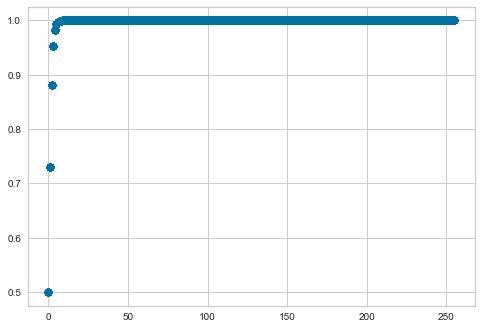

In [54]:
plt.scatter(x_test, sigmoid(x_test))
plt.show()

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9917
Precision: 0.9534883720930233
Recall: 0.9622448979591837


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


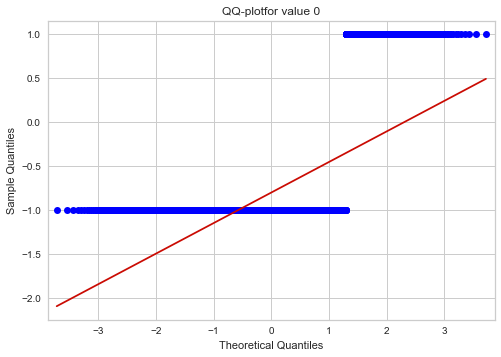

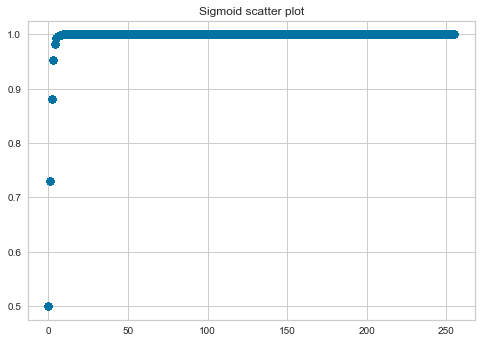

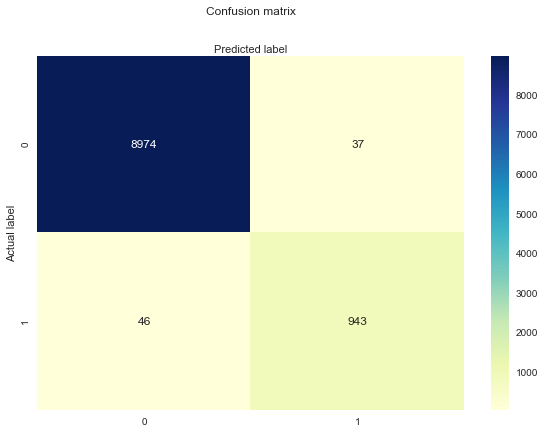

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9931
Precision: 0.9675438596491228
Recall: 0.9718061674008811


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


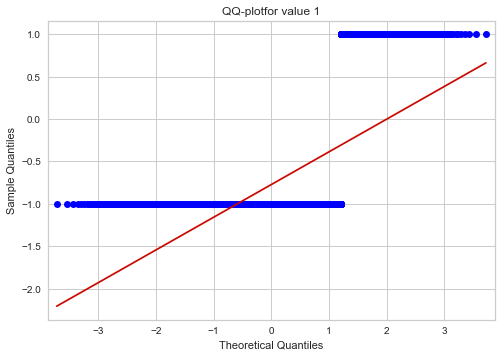

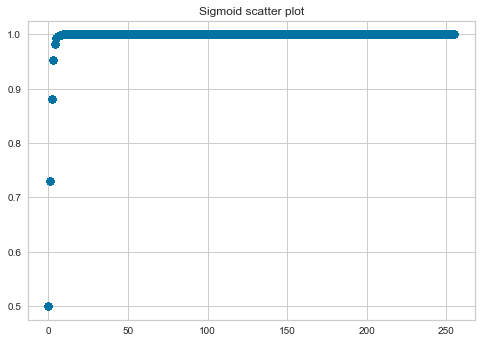

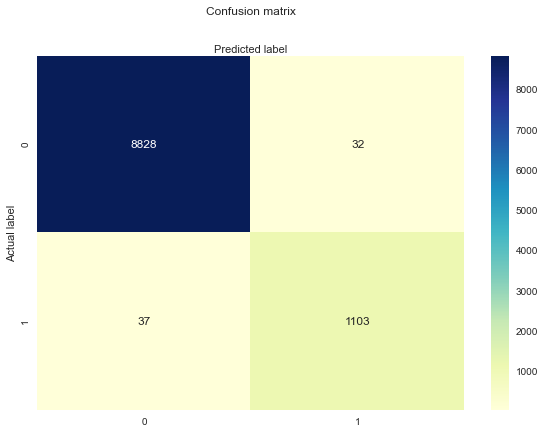

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9799
Precision: 0.9550930996714129
Recall: 0.8449612403100775


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


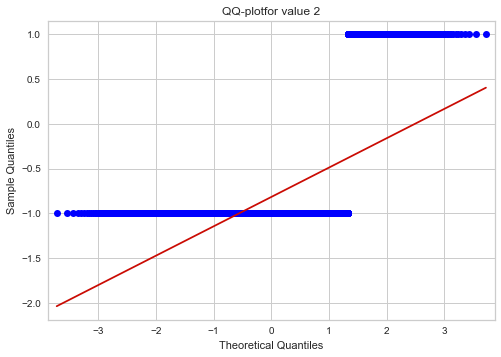

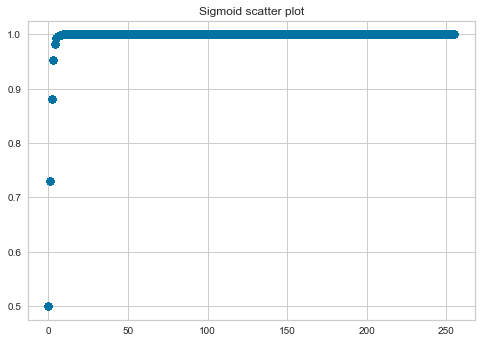

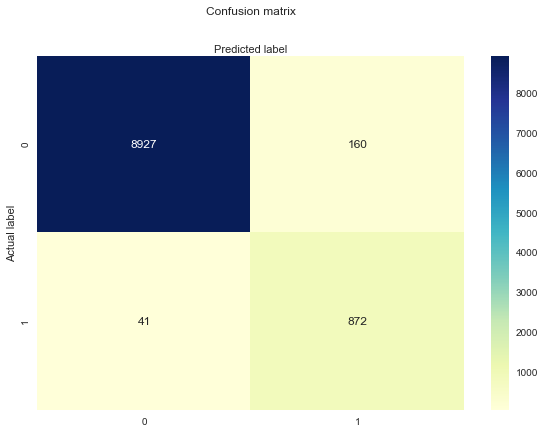

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.9768
Precision: 0.9138297872340425
Recall: 0.8504950495049505


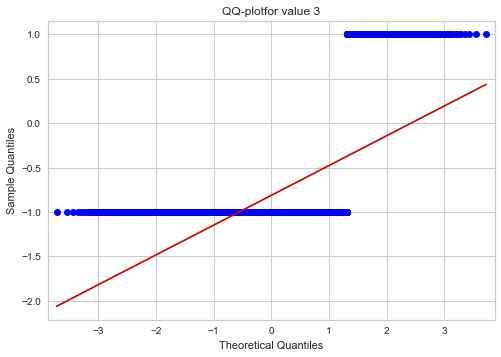

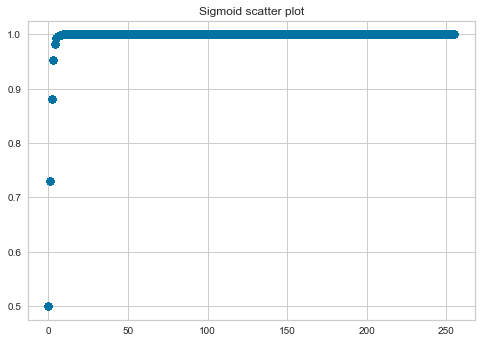

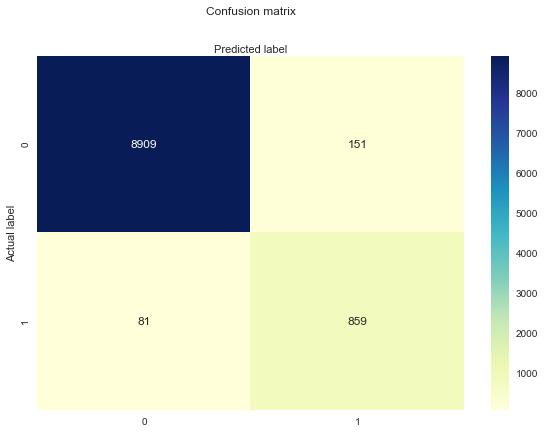

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9822
Precision: 0.9222689075630253
Recall: 0.8940936863543788


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


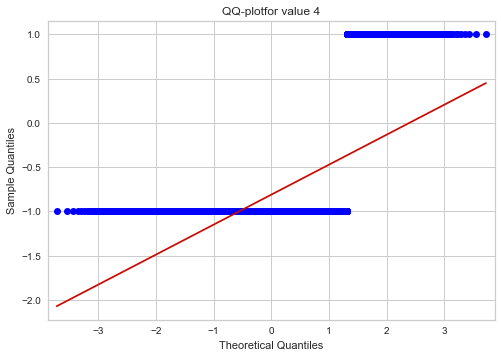

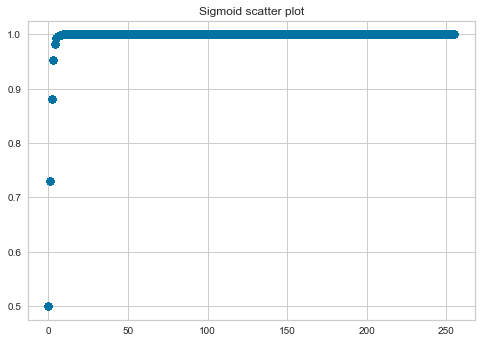

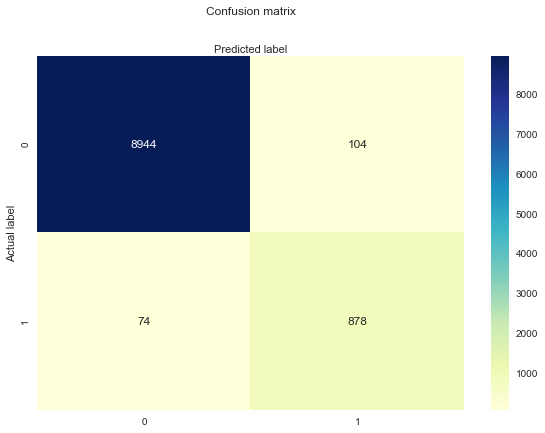

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.977
Precision: 0.9106699751861043
Recall: 0.8228699551569507


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


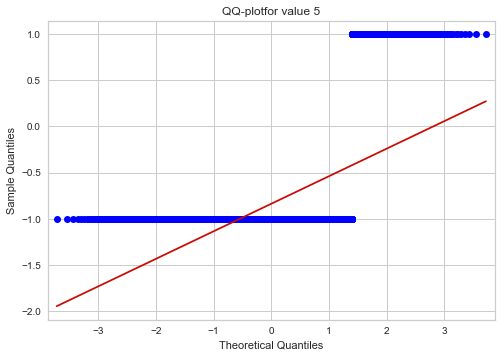

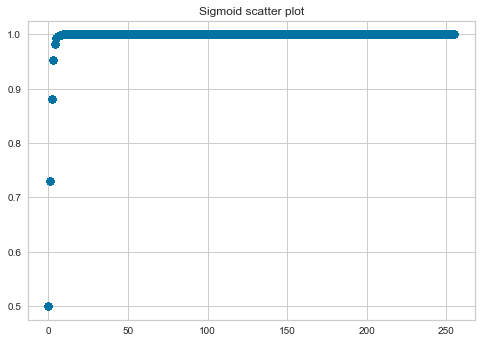

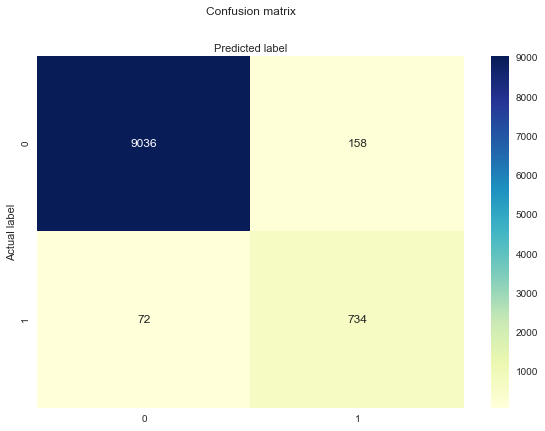

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9858
Precision: 0.9358974358974359
Recall: 0.9144050104384134


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


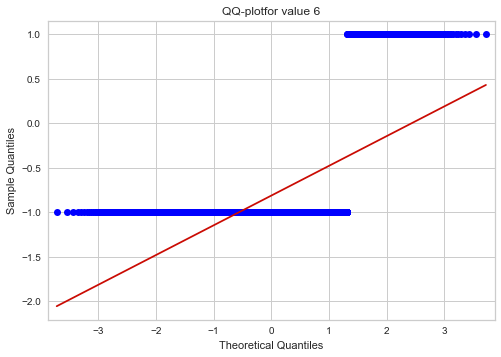

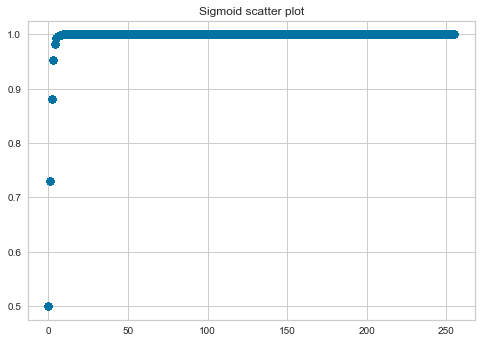

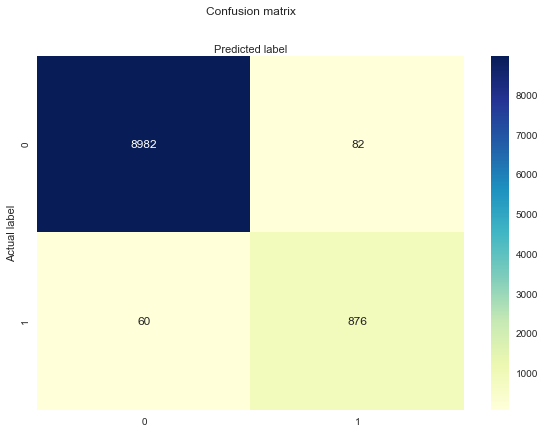

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9825
Precision: 0.9303733602421796
Recall: 0.896887159533074


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


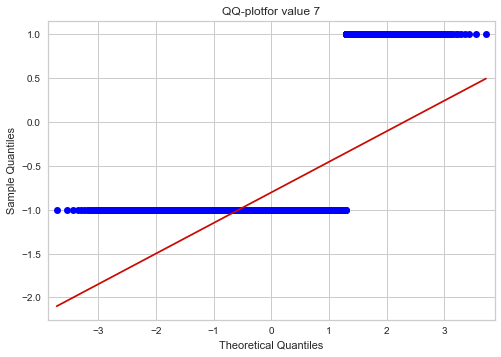

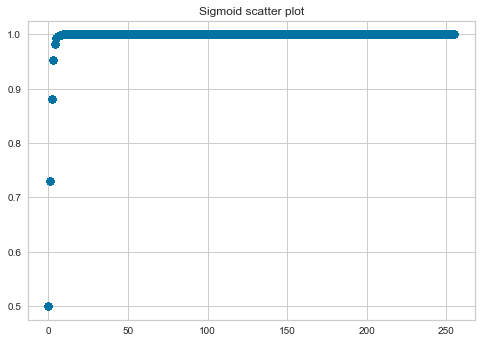

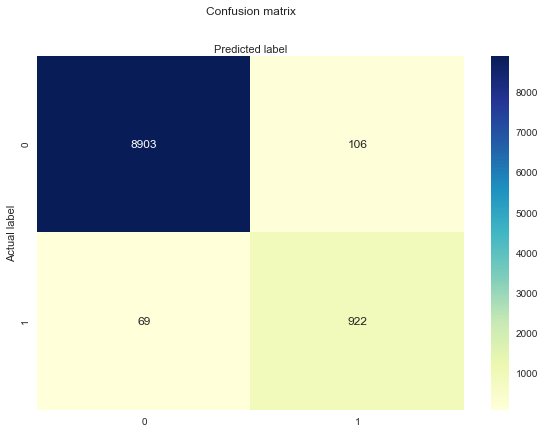

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.9617
Precision: 0.8472385428907168
Recall: 0.7402464065708418


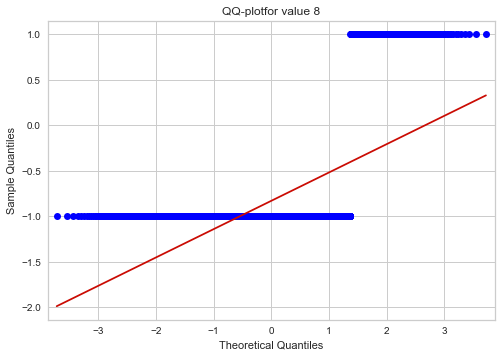

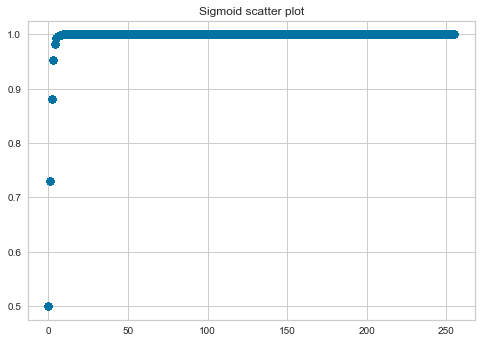

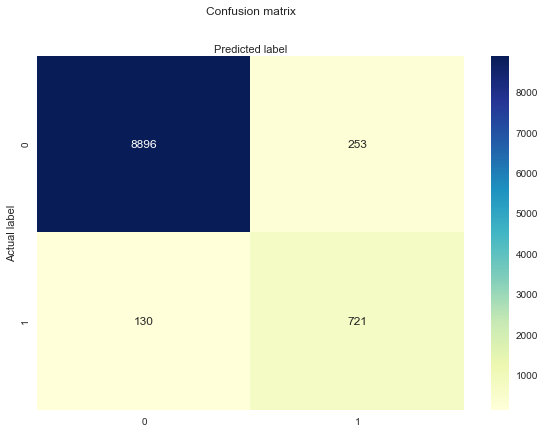

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9664
Precision: 0.8591248665955176
Recall: 0.7978196233894945


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


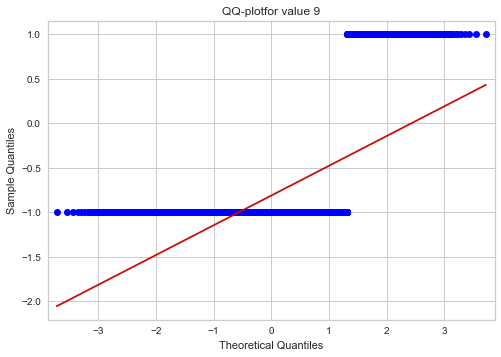

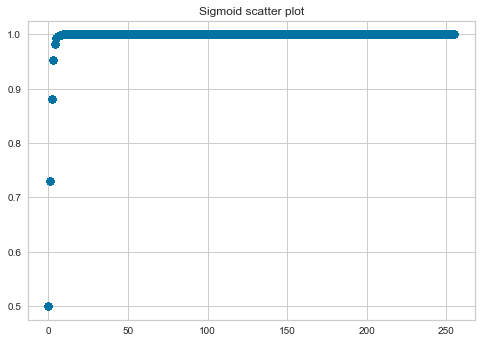

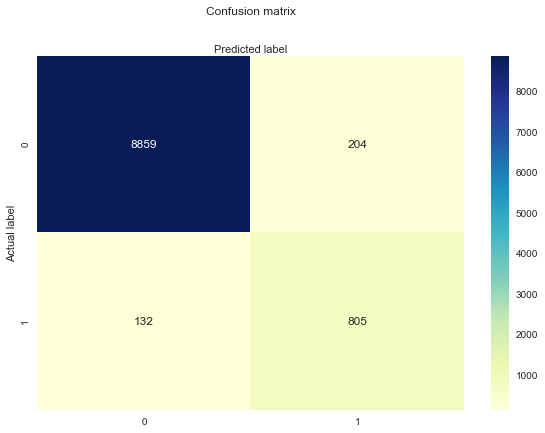

In [58]:
for t in range(0,10):
    x_train = oneD_bias_img(train['image'])
    y_train = binary_response(train['label'], t)
    betaa  = beta(x_train, y_train)
    
    y_test = binary_response(test['label'], t)
    
    #transformm data from to standar scaler and then fits it to a logistic regression function.
    #It uses an interation of 200
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 200,  solver ='sag'))
    pipe.fit(x_train, y_train)
    
    #predicting the unseen values from the data set
    x_test = oneD_bias_img(test['image'])
    y_pred = pipe.predict(x_test)
    
    #prints the metrics of the classifier for each of the y preducted values from the test
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    
    #this will plot the qq plot to determine if the values are normally distributed
    sm.qqplot(y_pred, line ='r')
    plt.title(f"QQ-plotfor value {t}")
    plt.savefig("qq_plot_"+str(t)+ ".png")
    plt.show()
    
    #sigmoid scatter plot with x_test
    plt.scatter(x_test, sigmoid(x_test))
    plt.title("Sigmoid scatter plot")
    plt.savefig(f"sigmoid_plot_"+str(t))
    plt.show()
    
    #takes the probabilities of each value of happening
    #p = np.exp(x_test@betaa)/(1+ np.exp(x_test@betaa))
    #plt.scatter(p, y_pred)
    #plt.show()
    
    #plots the confusion matrix from the function above
    confusion_matrixx = confusion_matrix(y_pred, y_test)
    confusing_plot(confusion_matrixx, name = "matrix_for_"+str(t)+".png")

1.458164294236727


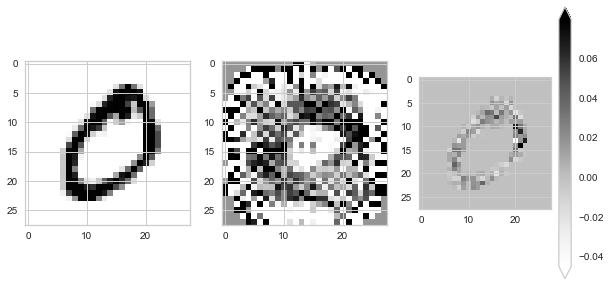

0.8895772185529442


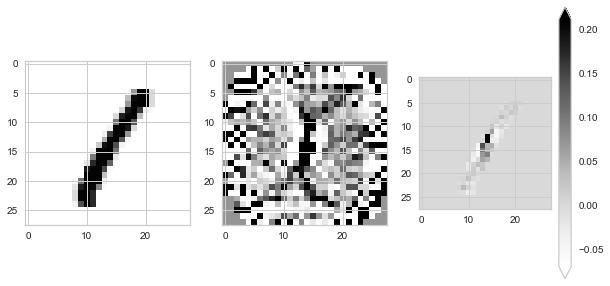

1.1316601772710024


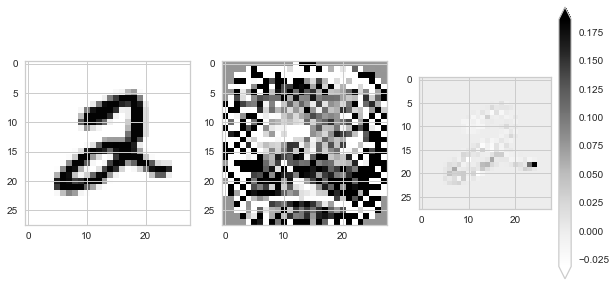

1.1931739925729696


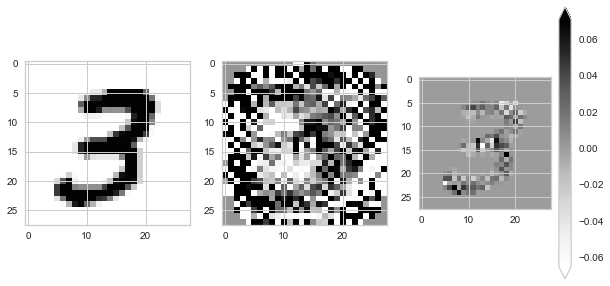

0.9527510315709959


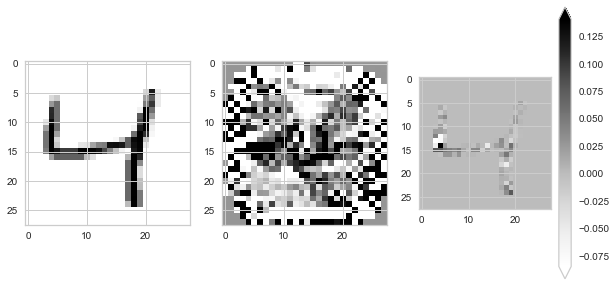

0.6451112257472048


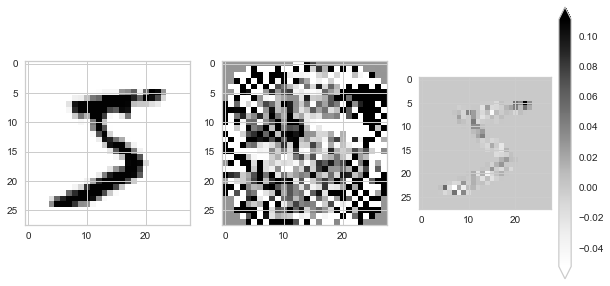

1.2376053260252495


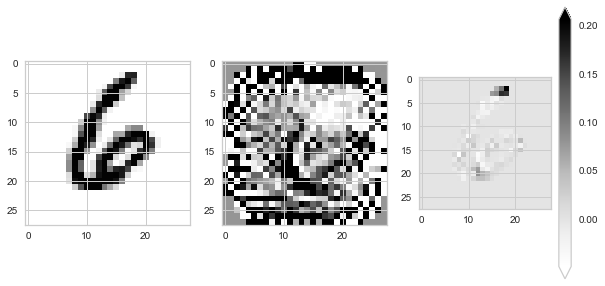

1.009812407709201


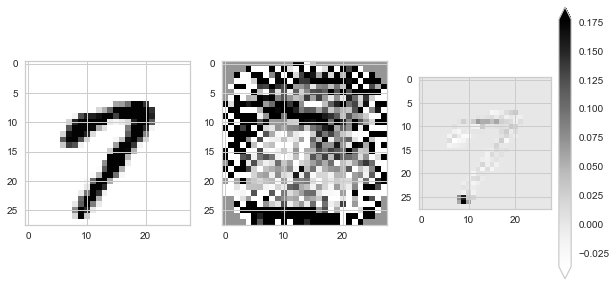

1.34434743666686


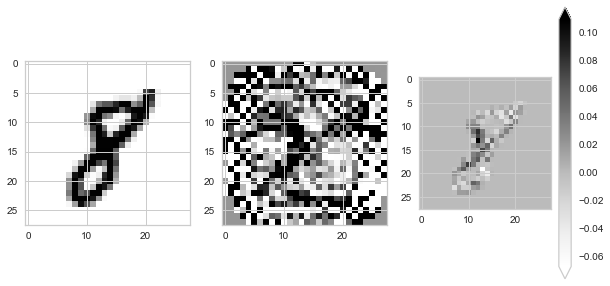

1.2580395455176543


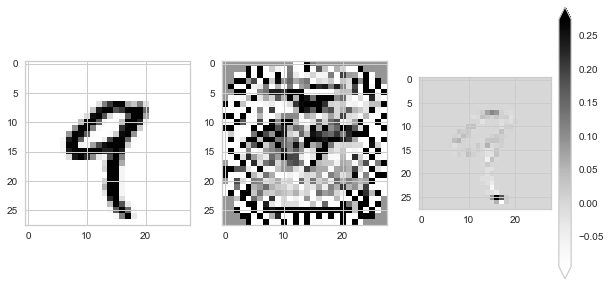

In [30]:
for t in range(0,10):
    x = oneD_bias_img(train['image'])
    y = binary_response(train['label'], t)
    betaa  = beta(x,y)
    
    print(np.dot(x[np.where(y==1)[0][0]][:784].T , betaa[:784].squeeze()))

    scale = 8
    p = (betaa[:784, 0].reshape(28,28))


    fig, axes = plt.subplots(1, 3, figsize=(10, 5) )
    ax = axes[0]
    ax.imshow(x[np.where(y==1)[0][0]][:784].reshape(28,28))
    
    x[np.where(y==1)[0][0]][:784].reshape(28,28)
    
    ax = axes[1]
    ax.imshow(p,vmin=-0.001/scale, vmax=0.001/scale)
    
    ax = axes[2]
    aa = ax.imshow(x[np.where(y==1)[0][0]][:784].reshape(28,28) * p)
    cbar = fig.colorbar(aa, ax=ax, extend='both')
    plt.show()